In [2]:
import qutip as qt
import QNN as qnn
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

2024-09-24 14:36:08.974453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 14:36:08.974467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 14:36:08.974992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


In [3]:
df = pd.read_csv('Parameters/Kerr/Function_1/parameters_fold_1.csv')

for i in range(2): 
    df[f'Layer{i}_bx'] = df[[f'Layer{i}_bx', f'Layer{i}_bp']].apply(tuple, axis=1)
    
    df = df.drop(columns=[f'Layer{i}_bp'])
    df = df.rename(columns={f'Layer{i}_bx': f'Layer{i}_bx_bp'})

In [4]:
def state(x, dim, epoch, layer, sublayer, params = df):
    
    psi = qnn.get_vacuum_state_tf(dim)
    psi = tf.matmul(qnn.squeezing_operator(dim, r=100), psi)
    psi = tf.matmul(qnn.displacement_operator(dim, x/2, 0.0), psi)
    
    if epoch == 0 or layer == 0 or sublayer == 0:
        psi = tf.squeeze(psi, axis=-1)
        psi = psi.numpy()
        return qt.Qobj(psi)
    else:
        N = layer*sublayer
        P = []
        for i in range(1,N+1):
            P.append(params[params.columns[i]][epoch+1])

    ops = [qnn.rotation_operator, qnn.squeezing_operator, qnn.rotation_operator, qnn.displacement_operator, qnn.kerr_operator]
    num_ops = len(ops)
    for i in range(N):
        op = ops[i % num_ops]
        if op == qnn.displacement_operator:
            psi = tf.matmul(op(dim, *P[i]), psi)
        else:
            psi = tf.matmul(op(dim, P[i]), psi)    

    psi = tf.squeeze(psi, axis=-1)
    psi = psi.numpy()
    
    return qt.Qobj(psi)

In [5]:
def wigner_log_negativity(state, L=5, N=100):
    # Create a grid in phase space
    x = np.linspace(-L, L, N)
    p = np.linspace(-L, L, N)
    X, P = np.meshgrid(x, p)
    
    # Compute Wigner function on the grid
    W = np.vectorize(lambda x, p: qt.wigner(state, x, p))(X, P)
    
    # Compute the integral of the absolute value
    dxdp = (2*L/N-1))**2  # Area element
    integral = np.sum(np.abs(W)) * dxdp
    
    # Compute log negativity
    log_negativity = np.log(integral)
    
    return log_negativity

In [18]:
from matplotlib import cm

def wigner_plot(x, dim = 20, epoch = 0, layer = 0, sublayer = 0):
    psi = state(x, dim, epoch, layer, sublayer)
    
    xvec = np.linspace(-7, 7, 1000)
    pvec = xvec
    W = qt.wigner(psi, xvec, pvec)

    wmap = qt.wigner_cmap(W)
    nrm = mpl.colors.Normalize(-W.max(), W.max())
    wplot = plt.figure(figsize=(8,8))
    wplot = plt.contourf(xvec, xvec, W, 100, cmap=wmap)  
    plt.gca().set_aspect('equal')

    # WLN = wigner_log_negativity(psi)
    # print(f'Wigner Log Negativity: {WLN}')

    plt.title("Wigner Colormap")
    cb2 = plt.colorbar(wplot)

    #plt.tight_layout()
    
    plt.show()

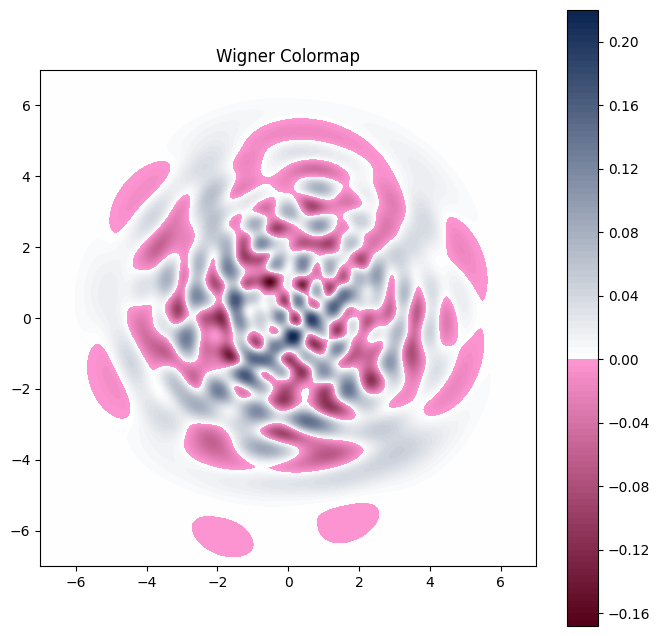

In [21]:
wigner_plot(-1.5, epoch=278, layer=3, sublayer=4)